```mermaid
%%{
  init: {
    'theme': 'base',
    'themeVariables': {
      'primaryColor': '#FFFFFF',
      'primaryTextColor': '#000000',
      'primaryBorderColor': '#000000',
      'lineColor': '#000000',
      'secondaryColor': '#FFFFFF',
      'tertiaryColor': '#fff',
      'clusterBkg': '#FFFFFF',
      'clusterBorder': '#000000'
    }
  }
}%%

flowchart LR

  %% User Section
  subgraph User
    researcher -->|affiliated with| institution
    researcher -->|participates in| project
    researcher -->|has account| blockchain_account
    researcher -->|collaborates with| researcher2
    researcher2
  end

  %% Project Section
  subgraph Project
    project -->|has| project_metadata
    project -->|stores| file
    project -->|created by| researcher
    project -->|linked to| blockchain_account
    project -->|associated with| institution
    project -->|has owner| project_owner
  end
  
  %% File Section
  subgraph File
    file -->|has| file_metadata
    file -->|linked to| project
    file -->|stored in| ipfs
  end
  
  %% Blockchain Section
  subgraph Blockchain
    blockchain_account -->|linked to| project
    blockchain_account -->|has attributes| project_account_attributes
    blockchain_account -->|stores CID for| file
  end
  
  %% Metadata Section
  subgraph Metadata
    project_metadata -->|describes| project
    file_metadata -->|describes| file
    project_metadata -->|has keywords| keyword
  end
  
  %% Institution Section
  subgraph Institution
    institution -->|affiliated with| researcher
    institution -->|participates in| project
  end
  
  %% IPFS Section
  subgraph IPFS
    ipfs -->|stores| file
    ipfs -->|stores| project_metadata
  end
```


Engine

In [6]:
import json
import networkx as nx
from pyvis.network import Network
from whoosh.index import open_dir
from whoosh.qparser import QueryParser

def build_knowledge_graph_from_projects(projects_data, search_results=None):
    """Build the knowledge graph based on JSON-LD projects data."""
    G = nx.Graph()

    # Iterate through the projects in @graph
    for project in projects_data['@graph']:
        project_id = project.get('schema:identifier', 'Unknown Project')
        project_name = project.get('schema:description', {}).get('schema:name', 'Unnamed Project')

        # Only add nodes for projects matching search results (if search_results provided)
        if search_results and project_id not in search_results:
            continue

        # Add project node with meaningful label
        G.add_node(project_id, label=project_name, type='Project')

        # Link project to its owner (linked_user)
        linked_user = project.get('schema:linked_user')
        if linked_user:
            G.add_node(linked_user, label=linked_user, type='User')
            G.add_edge(project_id, linked_user, label='Owner')

        # Extract project description details (startDate, endDate, location)
        project_start = project['schema:description'].get('schema:startDate', 'Unknown Start Date')
        project_end = project['schema:description'].get('schema:endDate', 'Unknown End Date')
        project_location = project['schema:description'].get('schema:location', {}).get('schema:name', 'Unknown Location')

        # Add project attributes as nodes or edge attributes (optional)
        G.add_node(f"{project_id}_date", label=f"Duration: {project_start} to {project_end}", type='Date')
        G.add_edge(project_id, f"{project_id}_date", label='Duration')
        
        G.add_node(f"{project_id}_location", label=project_location, type='Location')
        G.add_edge(project_id, f"{project_id}_location", label='Located in')

        # Link project to its files
        files = project.get('schema:files', [])
        for file_info in files:
            file_cid = file_info.get('file_cid', 'Unknown File')
            file_title = file_info['metadata'].get('dc:title', 'Untitled File')

            # Add file node with file title and metadata CID
            G.add_node(file_cid, label=file_title, type='File')
            G.add_edge(project_id, file_cid, label='Has File')

            # Add metadata CID node and link to file
            metadata_cid = file_info.get('metadata_cid', 'Unknown Metadata')
            G.add_node(metadata_cid, label=f"Metadata: {metadata_cid}", type='Metadata')
            G.add_edge(file_cid, metadata_cid, label='Has Metadata')

    return G

def visualize_graph(G):
    """Visualize the knowledge graph using pyvis."""
    net = Network(notebook=True, cdn_resources='in_line')  # Use inline resources for better Jupyter compatibility
    net.from_nx(G)  # Convert NetworkX graph to pyvis
    
    # Save and display the graph
    net.show('knowledge_graph.html')

def search_projects(query_str, index_dir):
    """Search projects using the Whoosh index."""
    ix = open_dir(index_dir)
    query_parser = QueryParser("content", ix.schema)
    
    with ix.searcher() as searcher:
        query = query_parser.parse(query_str)
        results = searcher.search(query)
        
        # Extract project identifiers from search results
        project_ids = [result['project_id'] for result in results]
        return project_ids

def main(query, projects_file, index_dir):
    """Main function to search and build a knowledge graph based on the search results."""
    # Load projects data from JSON
    with open(projects_file, 'r') as file:
        projects_data = json.load(file)
    
    # Search projects using the search engine
    search_results = search_projects(query, index_dir)
    
    # Build the knowledge graph based on search results
    G = build_knowledge_graph_from_projects(projects_data, search_results)
    
    # Visualize the graph
    visualize_graph(G)

# File path to projects.json and Whoosh index directory
projects_file = 'datasets/projects.json'
index_dir = 'indexdir'

# Example search query
query = "urban sprawl"

# Run the main function to search and visualize the results
main(query, projects_file, index_dir)


knowledge_graph.html


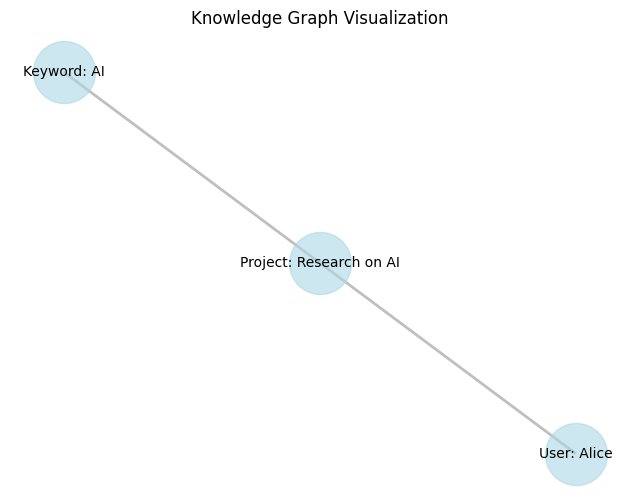

,Name,Description
0,User: Alice,User: Alice (User)
1,Project: Research on AI,Project: Research on AI (Project)
2,Keyword: AI,Keyword: AI (Keyword)


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Create the knowledge graph
def create_sample_knowledge_graph():
    G = nx.Graph()
    G.add_node("User: Alice", type="User")
    G.add_node("Project: Research on AI", type="Project")
    G.add_node("Keyword: AI", type="Keyword")
    
    G.add_edge("User: Alice", "Project: Research on AI", label="manages")
    G.add_edge("Project: Research on AI", "Keyword: AI", label="has keyword")
    
    return G

# Draw the graph
def draw_graph(G):
    pos = nx.spring_layout(G)  # positions for all nodes
    plt.figure(figsize=(8, 6))
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title("Knowledge Graph Visualization")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Search results
search_results = [
    ("User: Alice", "User: Alice (User)"),
    ("Project: Research on AI", "Project: Research on AI (Project)"),
    ("Keyword: AI", "Keyword: AI (Keyword)")
]

# Create the knowledge graph and visualize it
G = create_sample_knowledge_graph()
draw_graph(G)

# Convert search results to a DataFrame
df_results = pd.DataFrame(search_results, columns=["Name", "Description"])

# Display results
df_results

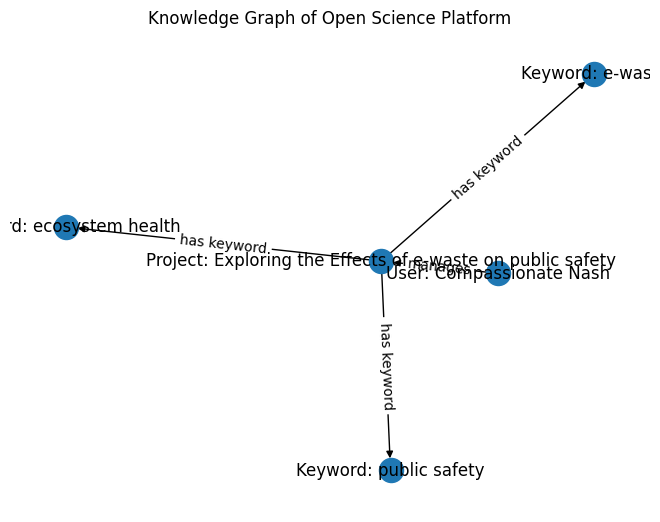

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample JSON-LD data
jsonld_data = {
    "@context": {
        "User": "https://schema.org/Person",
        "Project": "https://schema.org/CreativeWork",
        "Keyword": "https://schema.org/keywords"
    },
    "@graph": [
        {
            "@type": "User",
            "name": "Compassionate Nash",
            "email": "compassionate_nash@email.com",
            "affiliation": "Ecole Nationale Supérieure des Arts et Industries Textile",
            "role": "author"
        },
        {
            "@type": "Project",
            "title": "Exploring the Effects of e-waste on public safety",
            "abstract": "This study aims to investigate the effects of e-waste on public safety and propose strategies for improvement.",
            "startDate": "2019-11-06",
            "endDate": "2022-01-28",
            "funder": "European Union Horizon 2020",
            "keywords": ["e-waste", "public safety", "ecosystem health"]
        }
    ]
}

# Create a new directed graph
G = nx.DiGraph()

# Add User node
user_data = jsonld_data['@graph'][0]
user_node = f"User: {user_data['name']}"
G.add_node(user_node, type='User')

# Add Project node
project_data = jsonld_data['@graph'][1]
project_node = f"Project: {project_data['title']}"
G.add_node(project_node, type='Project')

# Add Keyword nodes
for keyword in project_data['keywords']:
    keyword_node = f"Keyword: {keyword}"
    G.add_node(keyword_node, type='Keyword')
    G.add_edge(project_node, keyword_node, label='has keyword')

# Add edge from User to Project
G.add_edge(user_node, project_node, label='manages')

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'label')

nx.draw(G, pos, with_labels=True, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Knowledge Graph of Open Science Platform")
plt.show()
